In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt

#this step not mandatory , just for avoiding problem caused by 
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
TensorFlow version: 2.13.0
Keras version: 0.1.7
KerasNLP version: 0.7.0


In [3]:
# ***Read Train_Data and identify different classes***

# **--------------------------------------**

In [4]:
#read train_data
DATA_DIR = '/kaggle/input/llm-detect-ai-generated-text/'
data_data_train_final = pd.read_csv(DATA_DIR + "train_essays.csv")
# Display information about the DataFrame
print(data_data_train_final.info())

# Collect unique values in the 'generated' column
classes = data_data_train_final['generated'].unique()
maxsize = data_data_train_final['text'].apply(len).max()

# Print the unique values 

print('\n\n ### THIS IS THE CLASSES THAT WE HAVE : #',classes,'### The CLASS 1 REPRESENT TEXTS GENERATED BY IA AND THE CLASS 0 REPRESENT TEXTS GENERATED BY HUMAN\n\n')
data_data_train_final.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


 ### THIS IS THE CLASSES THAT WE HAVE : # [0 1] ### The CLASS 1 REPRESENT TEXTS GENERATED BY IA AND THE CLASS 0 REPRESENT TEXTS GENERATED BY HUMAN




,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


*  We can see that we have 2 classes. And we need to work on the dimension of the texts because they are really huge.

# ***Visualisation of train data***

# **--------------------------------------**

Text(0.5, 1.0, 'Distibution of classes in in train essays')

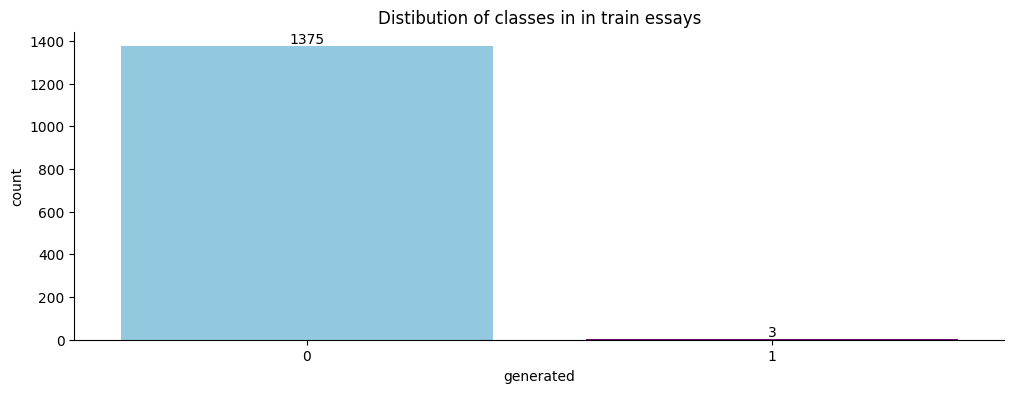

In [5]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=data_data_train_final,
                   x="generated", palette=['skyblue', 'purple'])

abs_values = data_data_train_final['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distibution of classes in in train essays")


generated
0    1375
1       3
Name: count, dtype: int64


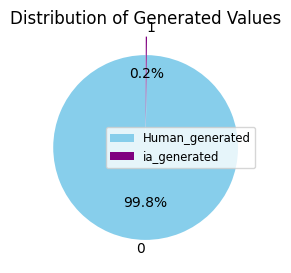

In [6]:
generated_count =data_data_train_final['generated'].value_counts()
print(generated_count)
labels = generated_count.index
explode = (0, 0.2)
plt.figure(figsize=(3,3))
plt.pie(generated_count, labels=labels, autopct='%1.1f%%', explode=explode, startangle=90,colors=['skyblue', 'purple'])
plt.title('Distribution of Generated Values')
legend_labels = ['Human_generated', 'ia_generated']
plt.legend(legend_labels, loc='right',fontsize='small')
plt.show()

* We can see that our Data is not balanced . So we will move to adding data to our data set in order to balance it .

# **Add New data**

# **--------------------------------------**

label
0    27371
1    17497
Name: count, dtype: int64


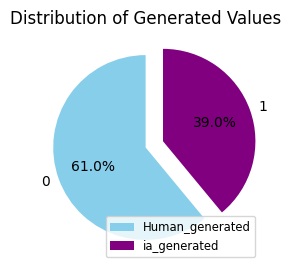

In [7]:
#LETS SEE THE DISTRIBUTION OF THE DATA THAT WE WILL ADD
new_data= pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
new_data.head(10)
generated_count =new_data['label'].value_counts()
print(generated_count)
labels = generated_count.index
explode = (0, 0.2)
plt.figure(figsize=(3,3))
plt.pie(generated_count, labels=labels, autopct='%1.1f%%', explode=explode, startangle=90 ,colors=['skyblue', 'purple'])
plt.title('Distribution of Generated Values')
legend_labels = ['Human_generated', 'ia_generated']
plt.legend(legend_labels, loc='lower right',fontsize='small')
plt.show()

In [8]:
#Here we will choose randomly data from the data that we will use to make our dataset balanced
# we will choose randomly essays that was written by ia and others written with human. 
new_data.rename(columns={'label':'generated'}, inplace=True)     ## Rename data
random_generated_data_ai = new_data[new_data['generated'] == 1].sample(n=2070, random_state=42)     ## Select 2000 random data point of ai genrated
random_generated_data_human = new_data[new_data['generated'] == 0].sample(n=700, random_state=42)   ## Select 2000 random data point of Human genrated

train_essay_selected = data_data_train_final[['text', 'generated']]
data_train_final = pd.concat([train_essay_selected, random_generated_data_ai[['text', 'generated']],random_generated_data_human[['text', 'generated']]])    ## Create data set for training containg label and Text
data_train_final = data_train_final.sample(frac=1, random_state=42).reset_index(drop=True)

generated
0    2075
1    2073
Name: count, dtype: int64


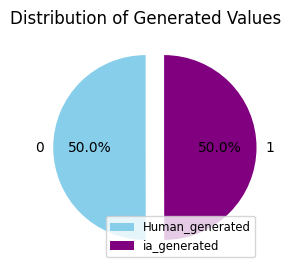

In [9]:
generated_count = data_train_final['generated'].value_counts()
print(generated_count)
labels = generated_count.index
explode = (0, 0.2)
plt.figure(figsize=(3,3))
plt.pie(generated_count, labels=labels, autopct='%1.1f%%', explode=explode, startangle=90 ,colors=['skyblue', 'purple'])
plt.title('Distribution of Generated Values')
legend_labels = ['Human_generated', 'ia_generated']
plt.legend(legend_labels, loc='lower right',fontsize='small')
plt.show()

Now our Data is balanced

# **Add New Test Data**

# **--------------------------------------**

In [10]:
# Load the CSV file into a DataFrame
df_test1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
df_test1.head()

# Remove the column labels
df_test = df_test1.iloc[2:]

# Keep only the desired columns and the first 10 rows for example
columns_to_keep = ['essay_id', 'text', 'source', 'fold']
df_test = df_test1[columns_to_keep].head(10)

# Display the resulting datasets
print("\n")
display(df_test1.head())
print("\n  • we removed the Labels from the data set and we kept the text and essays_id so that we can use this data to test our models. \n This is the final data set:\n")
print("\n")
display(df_test.head())


,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0



  • we removed the Labels from the data set and we kept the text and essays_id so that we can use this data to test our models. 
 This is the final data set:





,essay_id,text,source,fold
0,E897534557AF,"In recent years, technology has had a profoun...",mistral7binstruct_v2,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,persuade_corpus,2
2,af37ecf5,The electoral college is a symbol of mockery a...,train_essays,5
3,5EC2696BAD78,This is why I think the principle should allow...,persuade_corpus,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,llama_70b_v1,0


# **--------------------------------------**

   # **Models**

# **--------------------------------------**

> **Imports**

In [11]:
# Importing necessary libraries
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from prettytable import PrettyTable
import seaborn as sns
from tabulate import tabulate

# Importing necessary libraries FOR Transformers
from nltk.tokenize import sent_tokenize
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import plotly.graph_objects as go

> # **Unsepervised learning: K-mean++**

# **--------------------------------------------------------------**

* **Step 1 : Data Split & Vectorisation**
    * KMeans is an unsupervised learning algorithm,The labels are not used during the clustering process because KMeans doesn't rely on labeled data; it identifies patterns and groups based on the features

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_train_final['text'], data_train_final['generated'], test_size=0.2, random_state=42)
# Vectorisation
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

* **Step 2 : Clustering Model K-Means**

    1. Let's Choose the value of k : **Elbow Method** 
        * The Elbow Method involves running k-means clustering on the dataset for a range of values of k and calculating the sum of squared distances (inertia) from each point to its assigned center. **The point where the rate of decrease in inertia sharply changes** (**forming an "elbow" in the plot**) is often considered as **the optimal k**.
    

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


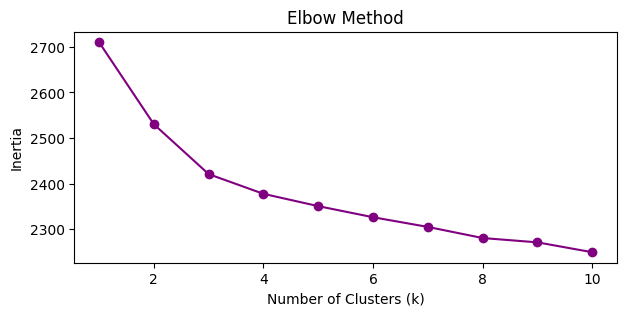

In [13]:
# Elbow Method
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_tfidf)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(7, 3))
plt.plot(k_values, inertias, marker='o', color='purple')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

* We can start see that we have an Elbow in the graph when the Number of Clusters **K=2**

2. **Define Model Parameters & Train:** 
     * in k-means++, the first centroid is chosen randomly from the data points, and subsequent centroids are chosen with a probability proportional to their distance from the existing centroids.
    * we will Run the K-mean++ algorithm 30 times => we will have 30 initial centriods one at a run
    * For each initial centriod we will run the k means 300times we may stop before 300 if we found the converge solution
    * in each 300: we will calculate the distance between each point and each centroids and also the mean(average) of all the points in a cluster(CENTROID) and we will update the location of the centriod

In [14]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=30, max_iter=300, random_state=42)
train_clusters = kmeans.fit_predict(X_train_tfidf)
test_clusters = kmeans.predict(X_test_tfidf)

* **Step 3: Plot the 2 K-Mean Clusters & Classes**
    * We first apply the **PCA**: To reduce the high-dimensional TF-IDF feature space to 2 dimensions PC1 & PC2. * In the **Scatter plot**: each point is represented by its coordinates in the reduced 2D space (X_train_pca[:, 0] and X_train_pca[:, 1]). 
    * **Scatter Plot for Actual Classes:** The first subplot (left side) displays a scatter plot where each point represents a data sample in the reduced 2D space. The **color of each point is determined by the actual class labels** (y_train). This plot helps **visualize the distribution and separation of actual classes in the reduced space**.
    * **Scatter Plot for K-Means Clusters:** The second subplot (right side) displays a scatter plot where each point represents a data sample, similar to the first subplot. However, the **color of each point is determined by the clusters assigned by the K-Means algorithm** (train_clusters). This plot helps visualize how well K-Means is able to group the data into clusters based on their similarity in the reduced space. 
 
    

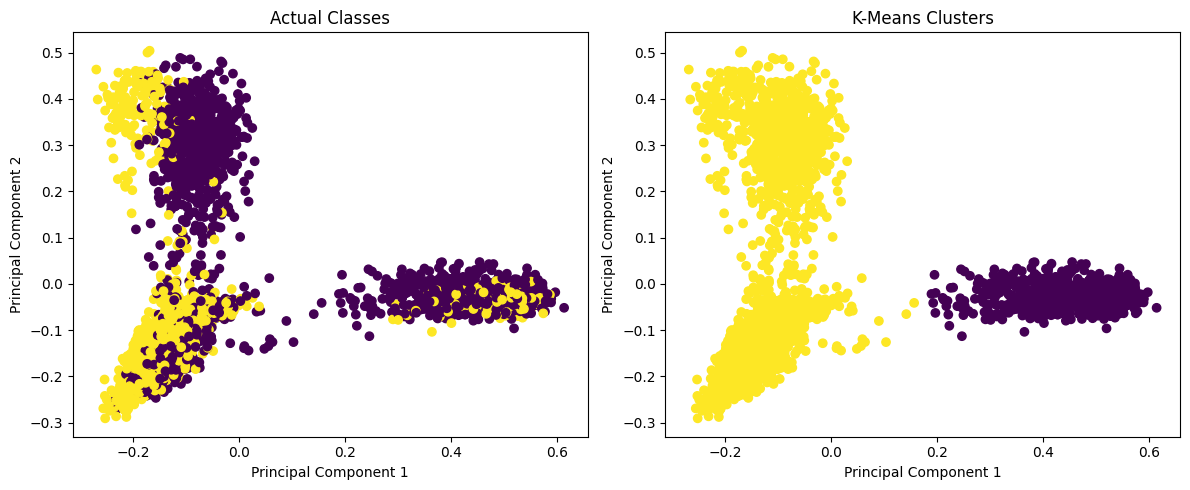

In [15]:
# Reduce dimensionality for visualization (assuming X_train_tfidf is sparse)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

# Scatter plot for actual classes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title('Actual Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Scatter plot for k-means clusters
plt.subplot(1, 2, 2)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis')
plt.title('K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

> **CONCLUSION: Relation between Actual Classes and K-Means Clusters:**
* By comparing the two scatter plots side by side, we can visually assess how well K-Means clustering aligns with the actual classes. If the colors in the K-Means Clusters plot correspond well to the colors in the Actual Classes plot, it indicates that the K-Means algorithm has successfully grouped the data points into clusters that align with the true classes. In our case **there's a mismatch, whitch means that the clustering might not be consistent with the true classes**. This visualization helps in understanding the performance of the clustering algorithm in relation to the actual class labels.

*  **Evaluation: Silhouette Score**
    * The silhouette score is a metric that measures how well-separated the clusters are. It ranges from -1 to 1, where a higher score indicates better-defined clusters and appropriately separated.

In [16]:
silhouette_avg = silhouette_score(X_train_tfidf, train_clusters)
print(f"Silhouette Score for Clustering: {silhouette_avg}")

Silhouette Score for Clustering: 0.04507088488188888


* **The result Around 0**: Indicates **overlapping clusters**, where the object could be assigned to either of the two neighboring clusters, or that the data points are very close to the decision boundary between clusters.

> # ***Simple Neural Network with 3 Dense Layers***

# **--------------------------------------------------------------**

* **Step 1: Load and Preprocess the Data**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_train_final['text'], data_train_final['generated'], test_size=0.2, random_state=42)

* **Step 2: Vectorisation,Encoding & Feature Extraction**
    * Vectorization: Refers to the process of converting data into a vector format that can be fed into a neural network
    * TF-IDF (Term Frequency-Inverse Document Frequency): measures the importance of a word in a document by considering both its frequency (TF) and its rarity (IDF). 
    * IDF penalizes common words that appear in many documents, while TF highlights words that are more relevant to the specific document.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_train_final['text'], data_train_final['generated'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Assigns a unique integer to each class in the label set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

* **Step 4: Neural Network Model**
    * The **First Layer** has 512 neurons, accepts an input with dimensions equal to the number of features obtained from the TF-IDF transformation
        * NOTE: X_train_tfidf.shape[1] : accesses the second element of the tuple, which is the number of features.
    * **Dropout** is a regularization technique used to ***prevent overfitting***
        * NOTE: The dropout rate is a Hyperparameter that determines the fraction of input units to drop during trainingduring training, 50% of the input units will be randomly set to zero at each update.
    * **Sigmoid** : the output represents the probability of the input belonging to class 1.
    * **Compile** : configure the learning process of the model before training.


In [19]:
model = Sequential()

model.add(Dense(512, input_dim=X_train_tfidf.shape[1], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

* **Step 5: Training the Model**
    * The model is trained on the training set, and the validation set is used during training to tune hyperparameters and monitor the model's performance

Epoch 1/10
94/94 [==============================] - 5s 11ms/step - loss: 0.2109 - precision: 0.9577 - recall: 0.8452 - val_loss: 0.0470 - val_precision: 0.9806 - val_recall: 0.9870
Epoch 2/10
94/94 [==============================] - 1s 7ms/step - loss: 0.0118 - precision: 0.9980 - recall: 0.9947 - val_loss: 0.0392 - val_precision: 0.9869 - val_recall: 0.9805
Epoch 3/10
94/94 [==============================] - 1s 6ms/step - loss: 0.0019 - precision: 1.0000 - recall: 0.9993 - val_loss: 0.0433 - val_precision: 0.9806 - val_recall: 0.9870
Epoch 4/10
94/94 [==============================] - 1s 7ms/step - loss: 4.1686e-04 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0478 - val_precision: 0.9806 - val_recall: 0.9870
Epoch 5/10
94/94 [==============================] - 1s 6ms/step - loss: 4.7776e-04 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0515 - val_precision: 0.9745 - val_recall: 0.9935
Epoch 6/10
94/94 [==============================] - 1s 6ms/step - loss: 1.9651e-04 - precis

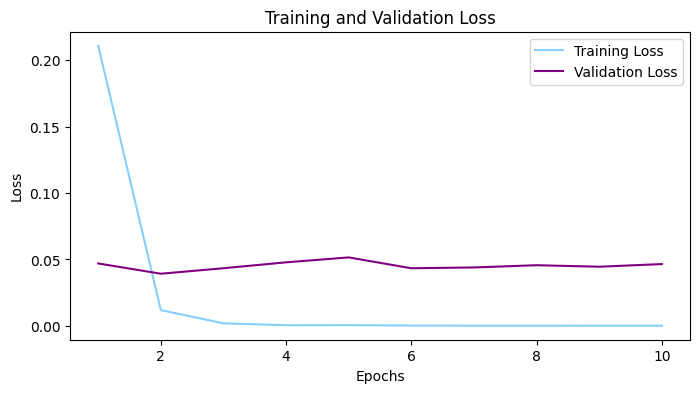

In [20]:
history = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=10, batch_size=32, validation_split=0.1)

# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Plotting the training and validation loss with custom colors
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, label='Training Loss', color='lightskyblue')  
plt.plot(epochs, val_loss, label='Validation Loss', color='purple')

# Customizing the plot appearance
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

* **Step 6: Evaluation Of the Neural Network**

26/26 [==============================] - 0s 2ms/step

 • Classification Report for Neural Network Model:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       410
           1       0.99      1.00      0.99       420

    accuracy                           0.99       830
   macro avg       0.99      0.99      0.99       830
weighted avg       0.99      0.99      0.99       830



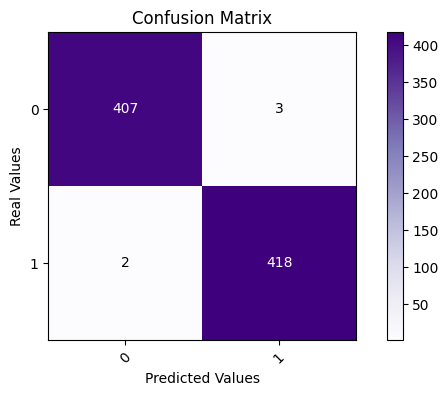

In [21]:
# Make Predictions on the Test Set
y_pred_proba = model.predict(X_test_tfidf.toarray())
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate Confusion Matrix and Plot it
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap="Purples")
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Values')
plt.ylabel('Real Values')

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > (conf_matrix.max() / 2) else 'black')

# Print the classification report
print("\n • Classification Report for Neural Network Model:")
print(classification_report(y_test_encoded, y_pred))

plt.show()

In [22]:
#Prediction for New Text
new_text_tfidf = vectorizer.transform(df_test['text'])
new_text_encoded = model.predict(new_text_tfidf.toarray())

# #Create a PrettyTable instance
# result_table = PrettyTable()
# result_table.field_names = ["Text_id", "Predictions", "Explanation_of_Prediction"]

# # Fill the table with results for each new text
# for i in range(len(df_test)):
#     text_id = df_test['essay_id'].iloc[i]
#     Explanation_of_Prediction = new_text_encoded[i]
#     prediction = 'AI Generated' if new_text_encoded[i] >= 0.5 else 'Human'
#     result_table.add_row([text_id,Explanation_of_Prediction ,prediction])

# # Print the result table
# print(result_table)

# Create a DataFrame directly from the original data
result_df = pd.DataFrame({
    "Text_id": df_test['essay_id'].tolist(),  # Ensure essay_id is a 1-dimensional list
    "Predictions": new_text_encoded.flatten(),  # Ensure new_text_encoded is flattened to 1D
    "Explanation_of_Prediction": ['AI Generated' if x >= 0.5 else 'Human' for x in new_text_encoded.flatten()]  # Flatten and process
})

# Specify the output file path
output_file_path = '/kaggle/working/submission.csv'

# Save the DataFrame to a CSV file
result_df.to_csv(output_file_path, index=False)

# Print a message indicating the file has been saved
print(f"Results have been saved to: {output_file_path}")

1/1 [==============================] - 0s 23ms/step
Results have been saved to: /kaggle/working/submission.csv
